<a href="https://colab.research.google.com/github/AtilioFPedroni/Pc__Gillespie/blob/main/PC_Gelispe_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q networkx matplotlib numpy pandas seaborn

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

rng = np.random.default_rng()

In [52]:
def processo_contato(g, lista_inicial_de_infectados, beta, mu, tf):
    
    # condicao inicial
    infectados = lista_inicial_de_infectados.copy()

    estados = {vertice: 0 for vertice in g.nodes()}
    
    for infectado in infectados:
        estados[infectado] = 1

    escala_de_tempo = 1.05

    t_real = []
    t_pg = [] # vai ser em múltiplos de 1.05
    n_infectados = []

    tempo_atual = 0.0
    auxiliar_expoente_do_tempo_atual = 0
    auxiliar_pg_do_tempo_atual = escala_de_tempo**auxiliar_expoente_do_tempo_atual

    n_infectados_atual = len(infectados)

    while tempo_atual <= tf:

        if n_infectados_atual == 0:
            break

        taxa_total = beta * len(infectados) + mu * len(infectados)

        dt = -np.log(1.0 - rng.random()) / taxa_total
        tempo_atual += dt # vou deixar aqui, para ser tecnicamente correto

        # definir qual processo vai acontecer
        z = rng.random()
        if (z < mu*len(infectados) / taxa_total):
            # acontecer um processo de cura

            posicao_do_infectado = rng.integers(0, len(infectados)) # escolhe um infectado ao acaso, na posicao da lista
            infectado = infectados.pop(posicao_do_infectado) # retirar o infectado da lista

            estados[infectado] = 0

            n_infectados_atual -= 1

        else: # é equivalente a fazer elseif (z < beta*len(infectados) / taxa_total + mu*len(infectados) / taxa_total)
            # vai acontecer um processo de infecção

            # escolher um infectado ao acaso
            posicao_do_infectado = rng.integers(0, len(infectados)) # escolhe um infectado ao acaso, na posicao da lista

            infectado = infectados[posicao_do_infectado]

            # escolher um vizinho ao acaso
            vizinho = rng.choice(list(g.neighbors(infectado))) # escolher um vizinho ao acaso

            if estados[vizinho] == 0:
                infectados.append(vizinho) # adiciona ele à lista
                estados[vizinho] = 1

                n_infectados_atual += 1
            # caso contrário, nada é feito de diferente
        
        while tempo_atual >= auxiliar_pg_do_tempo_atual: # apenas para contabilizar os casos raros que podem acontecer de passos maiores que a unidade (dt > 1)
            t_pg.append(auxiliar_pg_do_tempo_atual)
            t_real.append(tempo_atual)
            n_infectados.append(n_infectados_atual)

            auxiliar_expoente_do_tempo_atual += 1
            auxiliar_pg_do_tempo_atual = escala_de_tempo**auxiliar_expoente_do_tempo_atual

    return t_pg, t_real, n_infectados # sequencia dos tempos t e números de infectados em cada tempo, contínuo

In [54]:
#%%timeit -n 1 -r 1
def simulacao_1D(n, betas, mu=1.0, tf = 100, ni=1, n_amostras=1):
    results = {}

    G = nx.circulant_graph(n, [1])

    for beta in betas:
        results[beta] = []
        for id_da_amostra in range(n_amostras):
            lista_de_infectados_inicial = rng.choice(G.nodes(), size=ni).tolist()
            t_pg, t_real, n_infectados = processo_contato(G, lista_de_infectados_inicial, beta, mu, tf)

            df = pd.DataFrame({'t_pg': t_pg, 't_real' : t_real, 'n_infectados': n_infectados})
            df['beta'] = beta
            df['id_da_amostra'] = id_da_amostra

            results[beta].append(df)
        results[beta] = pd.concat(results[beta])
    results = pd.concat(results.values())
    return results

######################################  Parâmetros ##############################

n = 100
betas = [0.1, 1, 1.5, 3.29, 5]
mu = 1.0
tf = 100
ni = 1

results = simulacao_1D(n, betas, mu, tf, ni, n_amostras=10)

results

,t_pg,t_real,n_infectados,beta,id_da_amostra
0,1.000000,1.607350,0.0,0.1,0
1,1.050000,1.607350,0.0,0.1,0
2,1.102500,1.607350,0.0,0.1,0
3,1.157625,1.607350,0.0,0.1,0
4,1.215506,1.607350,0.0,0.1,0
...,...,...,...,...,...
90,80.730365,80.730409,77.0,5.0,9
91,84.766883,84.768163,74.0,5.0,9
92,89.005227,89.007567,65.0,5.0,9
93,93.455489,93.472581,67.0,5.0,9


## Tratando o DataFrame para fazer a média no tempo

In [55]:
results['t_medio'] = results.groupby(['beta', 't_pg'])['t_real'].transform('mean') # faz a mesma coisa, porém replicando o valor para as linhas agrupadas
results.sort_values(by=['beta','t_pg'])

,t_pg,t_real,n_infectados,beta,id_da_amostra,t_medio
0,1.000000,1.607350,0.0,0.1,0,1.894084
0,1.000000,2.180819,0.0,0.1,1,1.894084
1,1.050000,1.607350,0.0,0.1,0,1.894084
1,1.050000,2.180819,0.0,0.1,1,1.894084
2,1.102500,1.607350,0.0,0.1,0,1.894084
...,...,...,...,...,...,...
94,98.128263,98.130644,66.0,5.0,2,98.130969
94,98.128263,98.139620,67.0,5.0,4,98.130969
94,98.128263,98.130841,67.0,5.0,7,98.130969
94,98.128263,98.128280,71.0,5.0,8,98.130969


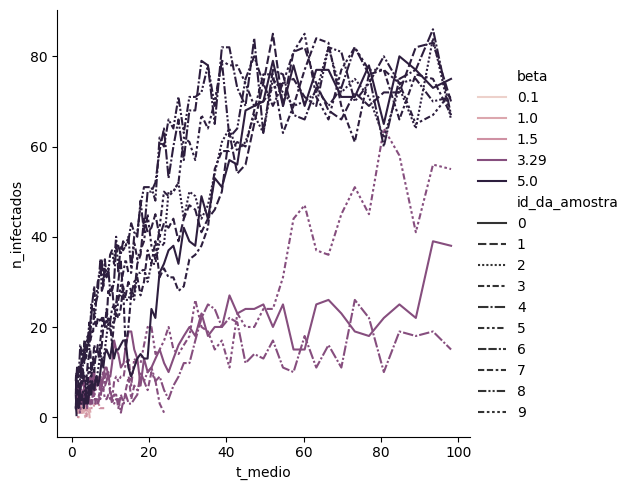

In [56]:
sns.relplot(data=results, x='t_medio', y='n_infectados', hue='beta', style='id_da_amostra', kind='line')

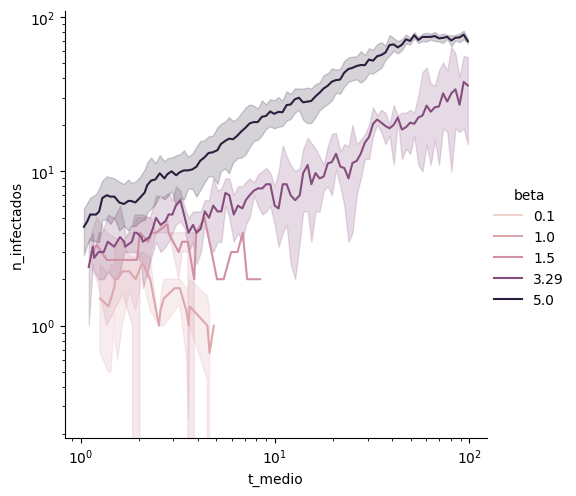

In [57]:
g = sns.relplot(data=results[results['t_medio'] > 0.0], x='t_medio', y='n_infectados', hue='beta', kind='line', markers=True)
g.set(xscale="log")
g.set(yscale="log")

# Exemplos

In [46]:
# exemplo
results[(np.isclose(results['beta'], 3.29))].groupby('id_da_amostra').size()

id_da_amostra
0    101
1      4
2     79
3     25
4    101
5    101
6      1
7     10
8    101
9     30
dtype: int64

In [40]:
pd.set_option('display.max_rows', 500)
results.groupby(['beta', 't_inteiro'])['t_real'].mean().iloc[0:500]

beta  t_inteiro
0.10  0.0            0.000000
      1.0            1.977713
      2.0            3.431013
      3.0            4.834172
      4.0            4.834172
1.00  0.0            0.000000
      1.0            1.625794
      2.0            2.538729
      3.0            3.327734
      4.0            4.771856
      5.0            5.298380
      6.0            6.029720
      7.0            7.531316
      8.0            8.217246
      9.0            9.031499
1.50  0.0            0.000000
      1.0            1.117308
      2.0            2.241753
      3.0            3.493299
      4.0            4.159590
      5.0            5.170605
      6.0            6.026116
3.29  0.0            0.000000
      1.0            1.092249
      2.0            2.040602
      3.0            3.095660
      4.0            4.096909
      5.0            5.039203
      6.0            6.098816
      7.0            7.042347
      8.0            8.047007
      9.0            9.046317
      10.0          10.0

In [25]:
for _, df in results.groupby(['beta','id_da_amostra']):
    if len(df) > 10:
        break
df

,t_inteiro,t_real,n_infectados,beta,id_da_amostra
0,0.0,0.000000,1,3.29,0
1,1.0,1.005349,3,3.29,0
2,2.0,2.070989,3,3.29,0
3,3.0,3.016718,2,3.29,0
4,4.0,4.300481,4,3.29,0
...,...,...,...,...,...
96,96.0,96.013060,22,3.29,0
97,97.0,97.003481,17,3.29,0
98,98.0,98.022754,16,3.29,0
99,99.0,99.005242,21,3.29,0
